In [65]:
# Listing 4.1 Example using Scikit-learn for a classification problem

import numpy as np
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

X, y = make_classification(
    n_features=32, n_redundant=0, n_informative=24, random_state=1, n_clusters_per_class=1
) #A

model = LogisticRegression() #B

pipeline = Pipeline(
    [('processing', StandardScaler()),
     ('modeling', model)]) #C

cv_scores = cross_validate(estimator=pipeline,
                           X=X,
                           y=y,
                           scoring="accuracy",
                           cv=5) #D

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
print(f"accuracy: {mean_cv:0.3f} ({std_cv:0.3f})") #E

model.fit(X, y) #F

#A generating a synthetic dataset with specified characteristics
#B creating an instance of the LogisticRegression model
#C creating a pipeline that sequentially applies standard scaling and the logistic regression model
#D performing a five-fold cross-validation using the defined pipeline, calculating accuracy scores
#E printing the mean and standard deviation of the test accuracy scores from cross-validation
#F fitting the logistic regression model to the entire dataset X with corresponding labels y

accuracy: 0.900 (0.032)


LogisticRegression()

In [19]:
# 4.1.2 Common Scikit-learn interface

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1.0)

X = [[-1, -1], [-2, -1], [1, 1], [2, 1]]
y = [1, 1, 0, 0]
model.fit(X, y)

LogisticRegression()

In [20]:
from sklearn.preprocessing import StandardScaler
processing = StandardScaler().fit(X)

In [21]:
X_test = [[-1, 1], [2, -1]]
model.predict(X_test)

array([1, 0])

In [22]:
model.predict_proba(X_test)

array([[0.45001898, 0.54998102],
       [0.73081591, 0.26918409]])

In [ ]:
processing.transform(X)

array([[-0.63245553, -1.        ],
       [-1.26491106, -1.        ],
       [ 0.63245553,  1.        ],
       [ 1.26491106,  1.        ]])

In [ ]:
processing.fit_transform(X)

array([[-0.63245553, -1.        ],
       [-1.26491106, -1.        ],
       [ 0.63245553,  1.        ],
       [ 1.26491106,  1.        ]])

In [23]:
# Loading Airbnb NY Dataset

import pandas as pd

url = "https://raw.githubusercontent.com/lmassaron/tabular_datasets/master/AB_NYC_2019.csv"
data = pd.read_csv(url)

In [24]:
# 4.2.1 Dataset exploration

import numpy as np
import pandas as pd
excluding_list = ['price', 'id', 'latitude', 'longitude', 'host_id', 'last_review',
                  'name', 'host_name'] #A
categorical = ['neighbourhood_group', 'neighbourhood', 'room_type'] #B
continuous = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
              'calculated_host_listings_count'] #C
data = pd.read_csv(url)

#A list of column names to be excluded from the analysis
#B list of names of columns that likely represent categorical variables in the dataset
#C list of names of columns that represent continuous numerical variables in the dataset.

In [25]:
data.shape

(48895, 16)

In [26]:
data[categorical].nunique()

,0
neighbourhood_group,5
neighbourhood,221
room_type,3


In [27]:
low_card_categorical = ['neighbourhood_group', 'room_type']
high_card_categorical = ['neighbourhood']

In [28]:
data[low_card_categorical + continuous].isna().sum()

,0
neighbourhood_group,0
room_type,0
minimum_nights,0
number_of_reviews,0
reviews_per_month,10052
calculated_host_listings_count,0


In [29]:
data.reviews_per_month.min()

0.01

array([[<Axes: title={'center': 'price'}>]], dtype=object)

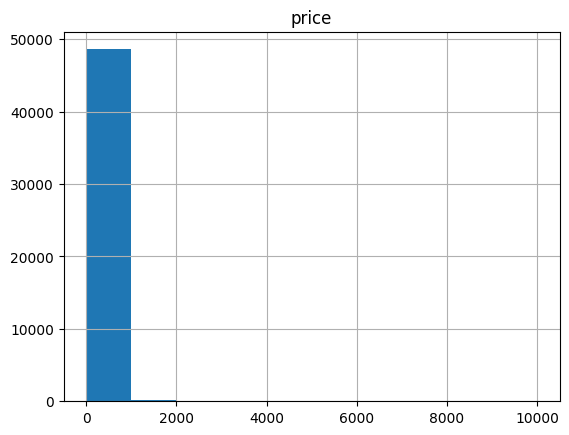

In [30]:
data[["price"]].hist(bins=10)

<Axes: >

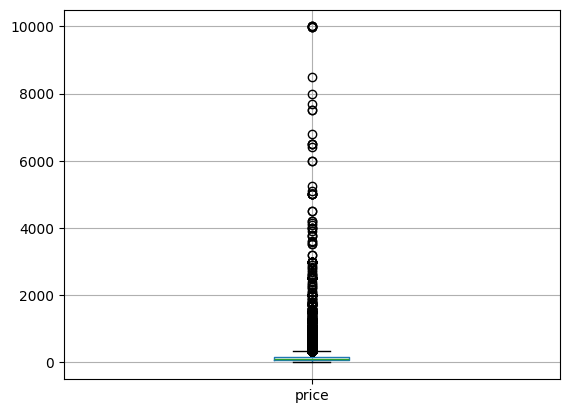

In [31]:
data[["price"]].boxplot()

<Axes: >

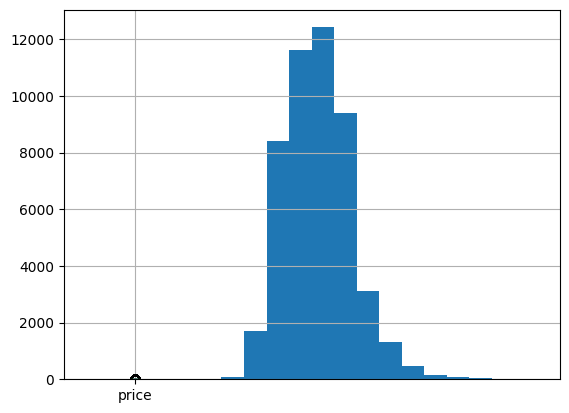

In [32]:
np.log1p(data["price"]).hist(bins=20)
data[["price"]].apply(lambda x: np.log1p(x)).boxplot()

array([[<Axes: title={'center': 'price'}>]], dtype=object)

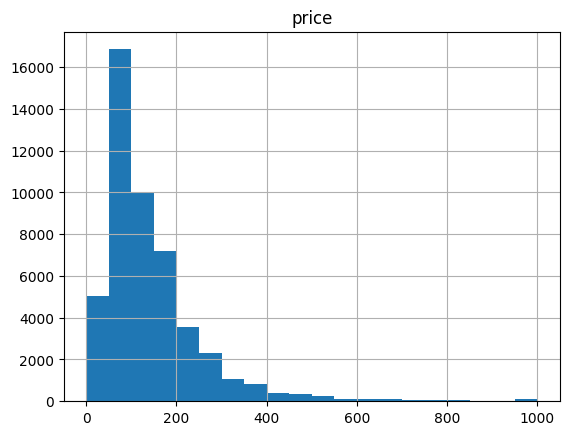

In [ ]:
data[["price"]][data.price <= 1000].hist(bins=20)

array([[<Axes: title={'center': 'price'}>]], dtype=object)

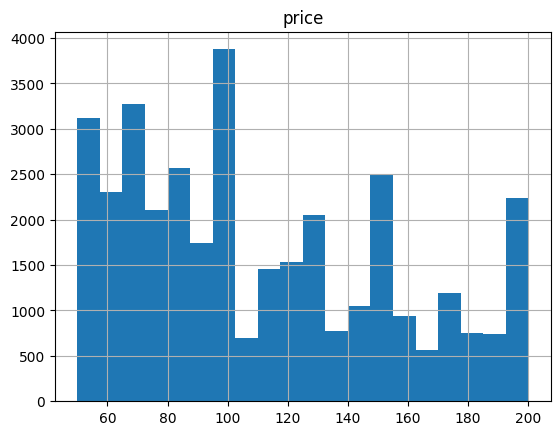

In [33]:
data[["price"]][(data.price >= 50) & (data.price <= 200)].hist(bins=20)

In [34]:
price_capped = data.price <= 1000
price_window = (data.price >= 50) & (data.price <= 200)

<Axes: >

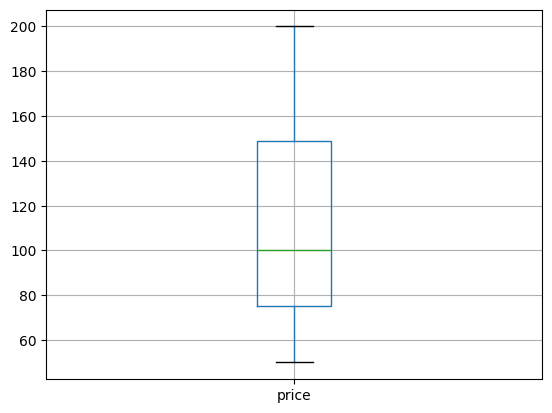

In [35]:
data[["price"]][price_window].boxplot()

In [36]:
target_mean = (data["price"] > data["price"].mean()).astype(int)
target_median = (data["price"] > data["price"].median()).astype(int)
target_multiclass = pd.qcut(data["price"], q=5, labels=False)
target_regression = data["price"]

In [37]:
target_median.value_counts()

,count
price,
0,24472
1,24423


In [38]:
target_mean.value_counts()

,count
price,
0,34016
1,14879


In [39]:
target_multiclass.value_counts()

,count
price,
3,10809
0,10063
1,9835
2,9804
4,8384


In [40]:
# Listing 4.2 setting up building blocks for tabular learning pipelines

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

categorical_onehot_encoding = OneHotEncoder(handle_unknown='ignore') #A
numeric_passthrough = SimpleImputer(strategy="constant", fill_value=0) #B
numeric_standardization = Pipeline([
       ("imputation", SimpleImputer(strategy="constant", fill_value=0)),
       ("standardizing", StandardScaler())
       ]) #C

#A converting categorical features into one-hot encoded format
#B replacing missing numeric values with zero
#C pipeline replacing missing numeric values with zero and standardizing the features

In [41]:
column_transform = ColumnTransformer(
    [('categories', categorical_onehot_encoding, low_card_categorical), #A
     ('numeric', numeric_passthrough, continuous), #B
    ],
    remainder='drop', #C
    verbose_feature_names_out=False, #D
    sparse_threshold=0.0 #E
)

#A first step of the pipeline, one-hot encoding categorical features
#B second step of the pipeline, handling numeric features
#C the features not processed by the pipeline are dropped from the result
#D names of the features are kept as they originally are
#E the result is always a dense matrix, i.e., a NumPy array

In [42]:
X = column_transform.fit_transform(data)
print(type(X), X.dtype, X.shape)

<class 'numpy.ndarray'> float64 (48895, 12)


In [69]:
# Listing 4.3 Linear regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
import numpy as np

column_transform = ColumnTransformer(
    [('categories', categorical_onehot_encoding, low_card_categorical),
     ('numeric', numeric_passthrough, continuous)],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0.0) #A

model = LinearRegression() #B

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('modeling', model)] #C
)

cv = KFold(5, shuffle=True, random_state=0) #D

# Fixed RMSE scorer - Option 1: Custom function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False) #E

cv_scores = cross_validate(estimator=model_pipeline,
                           X=data[price_window],
                           y=target_regression[price_window],
                           scoring=rmse_scorer,  # Use the custom scorer
                           cv=cv,
                           return_train_score=True,
                           return_estimator=True) #F

mean_cv = -np.mean(cv_scores['test_score'])  # Negative because greater_is_better=False
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})",
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs") #G

# Alternative Option 2: Using string-based scoring
"""
cv_scores = cross_validate(estimator=model_pipeline,
                           X=data[price_window],
                           y=target_regression[price_window],
                           scoring='neg_root_mean_squared_error',  # Built-in RMSE scorer
                           cv=cv,
                           return_train_score=True,
                           return_estimator=True)

mean_cv = -np.mean(cv_scores['test_score'])  # Convert negative score to positive
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})",
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs")
"""

#A ColumnTransformer, transforming data into numeric features and imputing missing data
#B vanilla linear regression model
#C pipeline assembling ColumnTransformer and model
#D cross-validation strategy based on five folds and random sampling
#E function for evaluation metric derived from mean squared error (custom RMSE)
#F automated cross-validate procedure
#G reporting the results in terms of evaluation metric, standard deviation, fitting, and prediction time

34.120 (0.300) fit: 0.05 secs pred: 0.01 secs


'\ncv_scores = cross_validate(estimator=model_pipeline,\n                           X=data[price_window],\n                           y=target_regression[price_window],\n                           scoring=\'neg_root_mean_squared_error\',  # Built-in RMSE scorer\n                           cv=cv,\n                           return_train_score=True,\n                           return_estimator=True)\n\nmean_cv = -np.mean(cv_scores[\'test_score\'])  # Convert negative score to positive\nstd_cv = np.std(cv_scores[\'test_score\'])\nfit_time = np.mean(cv_scores[\'fit_time\'])\nscore_time = np.mean(cv_scores[\'score_time\'])\nprint(f"{mean_cv:0.3f} ({std_cv:0.3f})",\n      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs")\n'

In [55]:
# Listing 4.4 Customized data preparation for linear regression

data_2 = data[[]].copy() #A
data_2['neighbourhood_group_Manhattan'] = (
   (data['neighbourhood_group']=='Manhattan').astype(int)) #B
data_2['neighbourhood_group_Queens'] = (
                           (data['neighbourhood_group']=='Queens').astype(int)) #C
data_2['room_type_Entire home/apt'] = (
                           (data['room_type']=='Entire home/apt').astype(int)) #D
data_2['minimum_nights_log'] = np.log1p(data["minimum_nights"]) #E
data_2['number_of_reviews_log'] = np.log1p(data["number_of_reviews"]) #F
data_2['neighbourhood_group_Manhattan*room_type_Entire home/apt'] = (
   data_2['neighbourhood_group_Manhattan'] * data_2['room_type_Entire home/apt']) #G
data_2['availability_365*neighbourhood_group_Manhattan'] = (data['availability_365'] *
   data_2['neighbourhood_group_Manhattan']) #H
data_2['availability_365*room_type_Entire home/apt'] = (data['availability_365'] *
   data_2['room_type_Entire home/apt']) #I

# Fixed RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

cv = KFold(5, shuffle=True, random_state=0)

cv_scores = cross_validate(estimator=LinearRegression(),
                           X=data_2[price_window],
                           y=target_regression[price_window],
                           scoring=rmse_scorer,  # Use the corrected scorer
                           cv=cv,
                           return_train_score=True,
                           return_estimator=True)

mean_cv = -np.mean(cv_scores['test_score'])  # Negative because greater_is_better=False
std_cv = np.std(cv_scores['test_score'])
print(f"{mean_cv:0.5f}, {std_cv:0.5f}")

#A creating  an empty DataFrame
#B a binary column indicating whether the 'neighbourhood_group' is 'Manhattan'.
#C binary column indicating whether the 'neighbourhood_group' is 'Queens'
#D binary column to indicating whether the 'room_type' is 'Entire home/apt'
#E a column containing the natural logarithm of the values in the 'minimum_nights' column plus 1
#F a column containing the natural logarithm of the values in the 'number_of_reviews' column plus 1
#G a product of the binary 'neighbourhood_group_Manhattan' and 'room_type_Entire home/apt' columns
#H a product of 'availability_365' and the binary 'neighbourhood_group_Manhattan' column
#I a product of 'availability_365' and the binary 'room_type_Entire home/apt' column

33.93737, 0.23999


In [56]:
# Listing 4.5 L2 regularized linear regression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
import numpy as np

column_transform = ColumnTransformer(
    [('categories', categorical_onehot_encoding, low_card_categorical),
     ('numeric', numeric_passthrough, continuous)],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0.0)

polynomial_expansion = PolynomialFeatures(degree=2) #A

model = Ridge(alpha=2500.0) #B

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('polynomial_expansion', polynomial_expansion),
     ('standardizing', numeric_standardization),
     ('modeling', model)]
) #C

cv = KFold(5, shuffle=True, random_state=0)

# Fixed RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

cv_scores = cross_validate(estimator=model_pipeline,
                           X=data[price_window],
                           y=target_regression[price_window],
                           scoring=rmse_scorer,  # Use the corrected scorer
                           cv=cv,
                           return_train_score=True,
                           return_estimator=True) #D

mean_cv = -np.mean(cv_scores['test_score'])  # Negative because greater_is_better=False
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})",
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs") #E

#A PolynomialFeatures instance performing second-degree polynomial expansion on the features
#B a Ridge regression model instance with a regularization strength (alpha) of 2500
#C pipeline for column transformation, polynomial expansion, standardization, and Ridge regression modeling
#D five-fold cross-validation using the defined pipeline and calculating RMSE scores
#E printing the mean and standard deviation of the test RMSE scores from cross-validation

33.936 (0.288) fit: 0.35 secs pred: 0.06 secs


In [66]:
# Listing 4.6 L1 regularized linear regression

model = Lasso(alpha=0.1) #A

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('polynomial_expansion', polynomial_expansion),
     ('standardizing', numeric_standardization),
     ('modeling', model)]
) #B

cv = KFold(5, shuffle=True, random_state=0)

# Fixed RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

cv_scores = cross_validate(estimator=model_pipeline,
                           X=data[price_window],
                           y=target_regression[price_window],
                           scoring=rmse_scorer,  # Use corrected scorer
                           cv=cv,
                           return_train_score=True,
                           return_estimator=True) #C

mean_cv = -np.mean(cv_scores['test_score'])  # Negative because greater_is_better=False
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})",
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs") #D

#A a Lasso regression model instance with a regularization strength (alpha) of 0.1
#B pipeline applying column transformation, polynomial expansion, standardization, and Lasso regression modeling
#C five-fold cross-validation using the defined pipeline and calculating RMSE scores
#D printing the mean and standard deviation of the test RMSE scores from cross-validation

33.902 (0.283) fit: 0.96 secs pred: 0.04 secs


In [58]:
# Listing 4.7 Logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score

accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)
model = LogisticRegression(solver="saga", penalty=None, max_iter=1_000) #A

column_transform = ColumnTransformer(
    [('categories', categorical_onehot_encoding, low_card_categorical),
     ('numeric', numeric_standardization, continuous)],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0.0) #B

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('modeling', model)]) #C

cv_scores = cross_validate(estimator=model_pipeline,
                           X=data,
                           y=target_median,
                           scoring=accuracy,
                           cv=cv,
                           return_train_score=True,
                           return_estimator=True) #D

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})",
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs") #E

#A a logistic regression model instance with the "saga" solver, no penalty, and a maximum of 1,000 iterations
#B a column transformer applying one-hot encoding to categorical features and standardization to numeric features
#C a pipeline that sequentially applies column transformation and logistic regression modeling
#D five-fold cross-validation using the defined pipeline and calculating accuracy scores
#E printing the mean and standard deviation of the test accuracy scores from cross-validation

0.820 (0.005) fit: 2.78 secs pred: 0.01 secs


In [67]:
# Listing 4.8 L2 regularized multiclass linear regression

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import make_scorer, accuracy_score

accuracy = make_scorer(accuracy_score)  # This is actually unnecessary since accuracy is default
cv = KFold(5, shuffle=True, random_state=0)

# Updated to address deprecation warning
base_model = LogisticRegression(penalty="l2", C=0.1, solver="sag", max_iter=1_000)
model = OneVsRestClassifier(base_model) #A

column_transform = ColumnTransformer(
    [('categories', categorical_onehot_encoding, low_card_categorical),
     ('numeric', numeric_standardization, continuous)],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0.0) #B

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('modeling', model)]) #C

cv_scores = cross_validate(estimator=model_pipeline,
                           X=data,
                           y=target_multiclass,
                           scoring='accuracy',  # Can use string or the scorer object
                           cv=cv,
                           return_train_score=True,
                           return_estimator=True) #D

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})",
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs") #E

#A OneVsRestClassifier wrapping LogisticRegression with L2 penalty, regularization C=0.1, "sag" solver
#B column transformer that applies one-hot encoding to categorical features and standardization to numeric features
#C pipeline that sequentially applies column transformation and logistic regression modeling
#D cross-validation using the defined pipeline and calculating accuracy scores
#E printing the mean and standard deviation of the test accuracy scores from cross-validation

0.425 (0.002) fit: 27.02 secs pred: 0.01 secs


In [64]:
# Listing 4.9 Tweedie regression

from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
import numpy as np

experiments = [
    ['normal', 0, float('-inf')],
    ['poisson', 1, 0.0],
    ['tweedie', 1.5, 0.1],
    ['gamma', 2, 0.1],
    ['inverse gaussian', 3, 0.1]] #A

# Fixed RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

for experiment, power, min_val in experiments: #B

    column_transform = ColumnTransformer(
        [('categories', categorical_onehot_encoding, low_card_categorical),
         ('numeric', numeric_standardization, continuous)],
        remainder='drop',
        verbose_feature_names_out=False,
        sparse_threshold=0.0)

    model = TweedieRegressor(power=power, max_iter=1_000) #C

    model_pipeline = Pipeline(
        [('processing', column_transform),
         ('modeling', model)])

    cv = KFold(5, shuffle=True, random_state=0)

    cv_scores = cross_validate(estimator=model_pipeline,
                               X=data,
                               y=target_regression.clip(lower=min_val), #D
                               scoring=rmse_scorer,  # Use corrected scorer
                               cv=cv,
                               return_train_score=True,
                               return_estimator=True)

    mean_cv = -np.mean(cv_scores['test_score'])  # Negative because greater_is_better=False
    std_cv = np.std(cv_scores['test_score'])
    fit_time = np.mean(cv_scores['fit_time'])
    score_time = np.mean(cv_scores['score_time'])
    print(f"{experiment:18}: {mean_cv:0.3f} ({std_cv:0.3f})",
          f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs") #E

#A a list of experiments, made of a distribution name, power parameter and minimum target value
#B looping through the experiments list with distribution names and power parameters
#C instance of the TweedieRegressor model with the specified power parameter for the current experiment
#D clipping the target regression data to a minimum value, accordingly to the used distribution
#E printing the experiment name along with the results from cross-validation

normal            : 233.858 (15.826) fit: 0.18 secs pred: 0.03 secs
poisson           : 229.189 (16.075) fit: 1.26 secs pred: 0.03 secs
tweedie           : 229.607 (16.047) fit: 0.41 secs pred: 0.03 secs
gamma             : 233.991 (15.828) fit: 0.15 secs pred: 0.02 secs
inverse gaussian  : 239.577 (15.453) fit: 0.07 secs pred: 0.02 secs


In [61]:
# Listing 4.10 Out-of-core Logistic regression with L2 regularization

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches
from sklearn.metrics import accuracy_score

def generate_batches(X, y, batch_size, random_state): #A
    """split dataset into batches """
    examples = len(X)
    batches = gen_batches(n=examples, batch_size=batch_size) #B
    sequence = np.arange(examples)
    if random_state:
      np.random.seed(random_state) #C
      np.random.shuffle(sequence)

    for batch in batches:
        items = sequence[batch]
        yield(X.iloc[items], y.iloc[items]) #D

model = SGDClassifier(loss="log_loss",
                      average=True,
                      penalty='l2',
                      alpha=0.001) #E

column_transform = ColumnTransformer(
    [('categories', categorical_onehot_encoding, low_card_categorical),
     ('numeric', numeric_standardization, continuous)],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0.0)

X_train, X_test, y_train, y_test = train_test_split(data, target_median,
                                                    test_size=0.20, random_state=0) #F
iterations = 10
for j in range(iterations): #G
    generator = generate_batches(X_train, y_train, batch_size=256, random_state=j)
    for k, (Xt, yt) in enumerate(generator):
        if k == 0:
            column_transform.fit(Xt)

        Xt = column_transform.transform(Xt)

        if k == 0:
            model.partial_fit(Xt, yt, classes=(0, 1)) #H
        else:
            model.partial_fit(Xt, yt) #I

predictions = model.predict(column_transform.transform(X_test))
score = accuracy_score(y_true=y_test, y_pred=predictions)
print(f"Accuracy on test set: {score:0.3f}") #J

#A defining a function to generate batches of data for training
#B generating batches of data indices for processing
#C shuffling the sequence of examples if a random state is provided
#D yielding batches of input features and corresponding labels
#E creating an instance of the SGDClassifier model with logistic loss, averaging, L2 penalty, and alpha regularization
#F splitting the data and target into training and testing sets using a 80-20 ratio
#G iterating through training data batches, fitting the column transformer on the first batch.
#H using partial fitting to train the model on the first batch, specifying the classes
#I using partial fitting to further train the model on subsequent batches
#J printing accuracy score of test data predictions

Accuracy on test set: 0.818
